In [5]:
import sys
sys.path.append("Person-Re-Id-Dataset-master")

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

## Configurations

In [7]:
DATA_DIR = "Person-Re-Id-Dataset-master/train/"
CSV_FILE = "Person-Re-Id-Dataset-master/train.csv"

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15
DEVICE = "cuda"

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [9]:
row = df.iloc[20]
A_img = io.imread(DATA_DIR + row.Anchor)
P_image = io.imread(DATA_DIR + row.Positive)
N_image = io.imread(DATA_DIR + row.Negative)

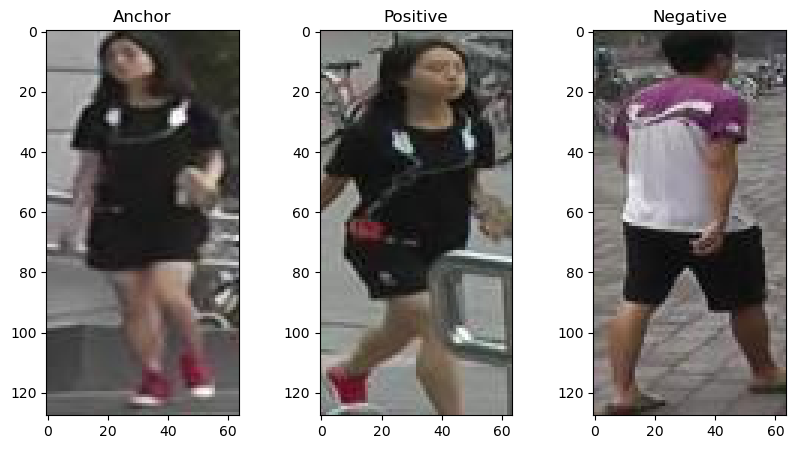

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))

ax1.set_title("Anchor")
ax1.imshow(A_img)
ax2.set_title("Positive")
ax2.imshow(P_image)
ax3.set_title("Negative")
ax3.imshow(N_image)

In [11]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

## Create APN Dataset

In [12]:
class APN_Dataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        A_img = io.imread(DATA_DIR + row.Anchor)
        P_image = io.imread(DATA_DIR + row.Positive)
        N_image = io.imread(DATA_DIR + row.Negative)

        A_img = torch.from_numpy(A_img).permute(2, 0, 1)/255.0
        P_image = torch.from_numpy(P_image).permute(2, 0, 1)/255.0
        N_image = torch.from_numpy(N_image).permute(2, 0, 1)/255.0

        return A_img, P_image, N_image

In [13]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 3200
Size of validset: 800


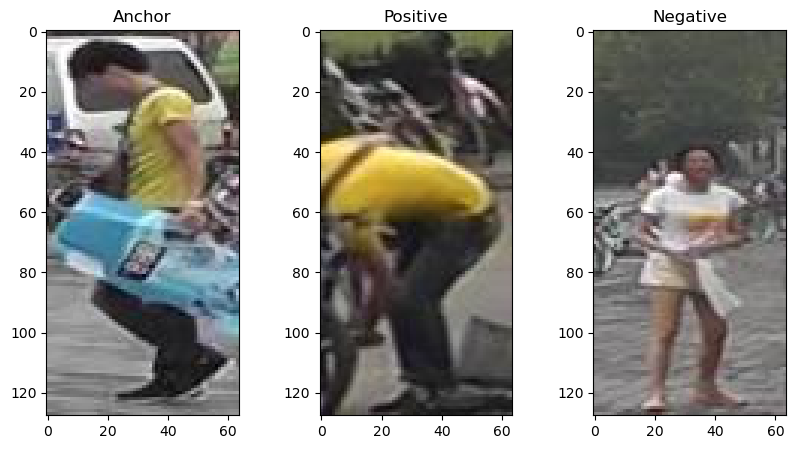

In [14]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

## Load Dataset into Batches

In [15]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [16]:
print(f"Number of batches in trainloader: {len(trainloader)}")
print(f"Number of batches in validloader: {len(validloader)}")

Number of batches in trainloader: 100
Number of batches in validloader: 25


In [17]:
for A, P, N in trainloader:
    break;

print(f"One image batch shape: {A.shape}")

One image batch shape: torch.Size([32, 3, 128, 64])


## Create Model

In [18]:
import timm
class APN_Model(nn.Module):
    def __init__(self, emb_size = 512):
        super(APN_Model, self).__init__()

        self.efficientnet = timm.create_model("efficientnet_b0", pretrained = True)
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

    def forward(self, images):
        embeddings = self.efficientnet(images)

        return embeddings

c:\Users\bharg\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
model = APN_Model()
model.to(DEVICE);

## Create Train and Eval function

In [21]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  
  return total_loss / len(dataloader)

In [22]:
def eval_fn(model, dataloader, criterion):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [23]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

## Training loop

In [43]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCESS")

  print(f"EPOCHS: {i+1} train_loss: {train_loss} valid_loss: {valid_loss}")

100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


TypeError: cannot unpack non-iterable float object

## Anchor Embeddings

In [27]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR + i)
            A = torch.from_numpy(A).permute(2, 0, 1)/255.0
            A = A.to(DEVICE)
            A_enc = model(A.unsqueeze(0))
            encodings.append(A_enc.squeeze().cpu().detach().numpy())
        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis=1)
    
    return df_enc


In [28]:
model.load_state_dict(torch.load("best_model.pt"))
df_enc = get_encoding_csv(model, df["Anchor"])

C:\Users\bharg\AppData\Local\Temp\ipykernel_60432\303838337.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))
100%|█████

In [29]:
df_enc.to_csv("database.csv", index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.211463,-0.108577,-0.088657,-0.460423,0.272211,-0.253344,0.224494,-0.573597,0.324161,...,0.024900,-0.421485,0.743964,-0.346189,-0.055339,0.058465,-0.045118,-0.089900,-0.090636,-0.576418
1,1420_c3s3_061978_03.jpg,0.638211,-0.190518,0.047723,-1.045072,1.281322,0.345431,0.228588,-0.549003,-0.061023,...,-0.084304,-0.207469,1.279144,-0.393819,0.710773,-0.370854,0.054353,-0.727206,-0.874465,-0.815609
2,1420_c5s3_062565_05.jpg,0.080452,-0.069243,0.173094,-0.828830,0.651198,0.011364,-0.021732,-0.564095,0.193541,...,-0.005130,-0.268011,1.062444,-0.484930,0.260416,-0.003632,-0.048056,-0.423082,-0.276276,-0.799191
3,1420_c6s3_085592_04.jpg,-0.081506,-0.269508,0.155889,-0.794971,1.027656,-0.062141,-0.261816,-0.360061,0.358970,...,-0.115021,-0.403593,1.518067,-0.176238,0.386413,0.300807,0.031703,-0.670112,-0.526443,-1.112638
4,0663_c5s3_085987_03.jpg,0.130630,-0.347343,0.086404,0.084572,-0.030191,-0.459850,-0.420133,0.951293,-0.528594,...,0.183493,0.253089,-0.073199,0.040047,-0.859349,1.203529,0.095388,-0.009074,1.014722,-0.162920


## Inference

In [30]:
def euclidean_dist(img_enc, ach_enc_arr):
    dist = np.sqrt(np.dot(img_enc-ach_enc_arr, (img_enc-ach_enc_arr).T))
    return dist

In [37]:
idx = 6
img_name = df_enc["Anchor"].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1)/255.0

model.eval()
with torch.no_grad():
    img = img.to(DEVICE)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()

In [38]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc["Anchor"]

In [39]:
distance = []
for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc, anc_enc_arr[i:i+1, :])
    distance = np.append(distance, dist)

In [40]:
closest_idx = np.argsort(distance)

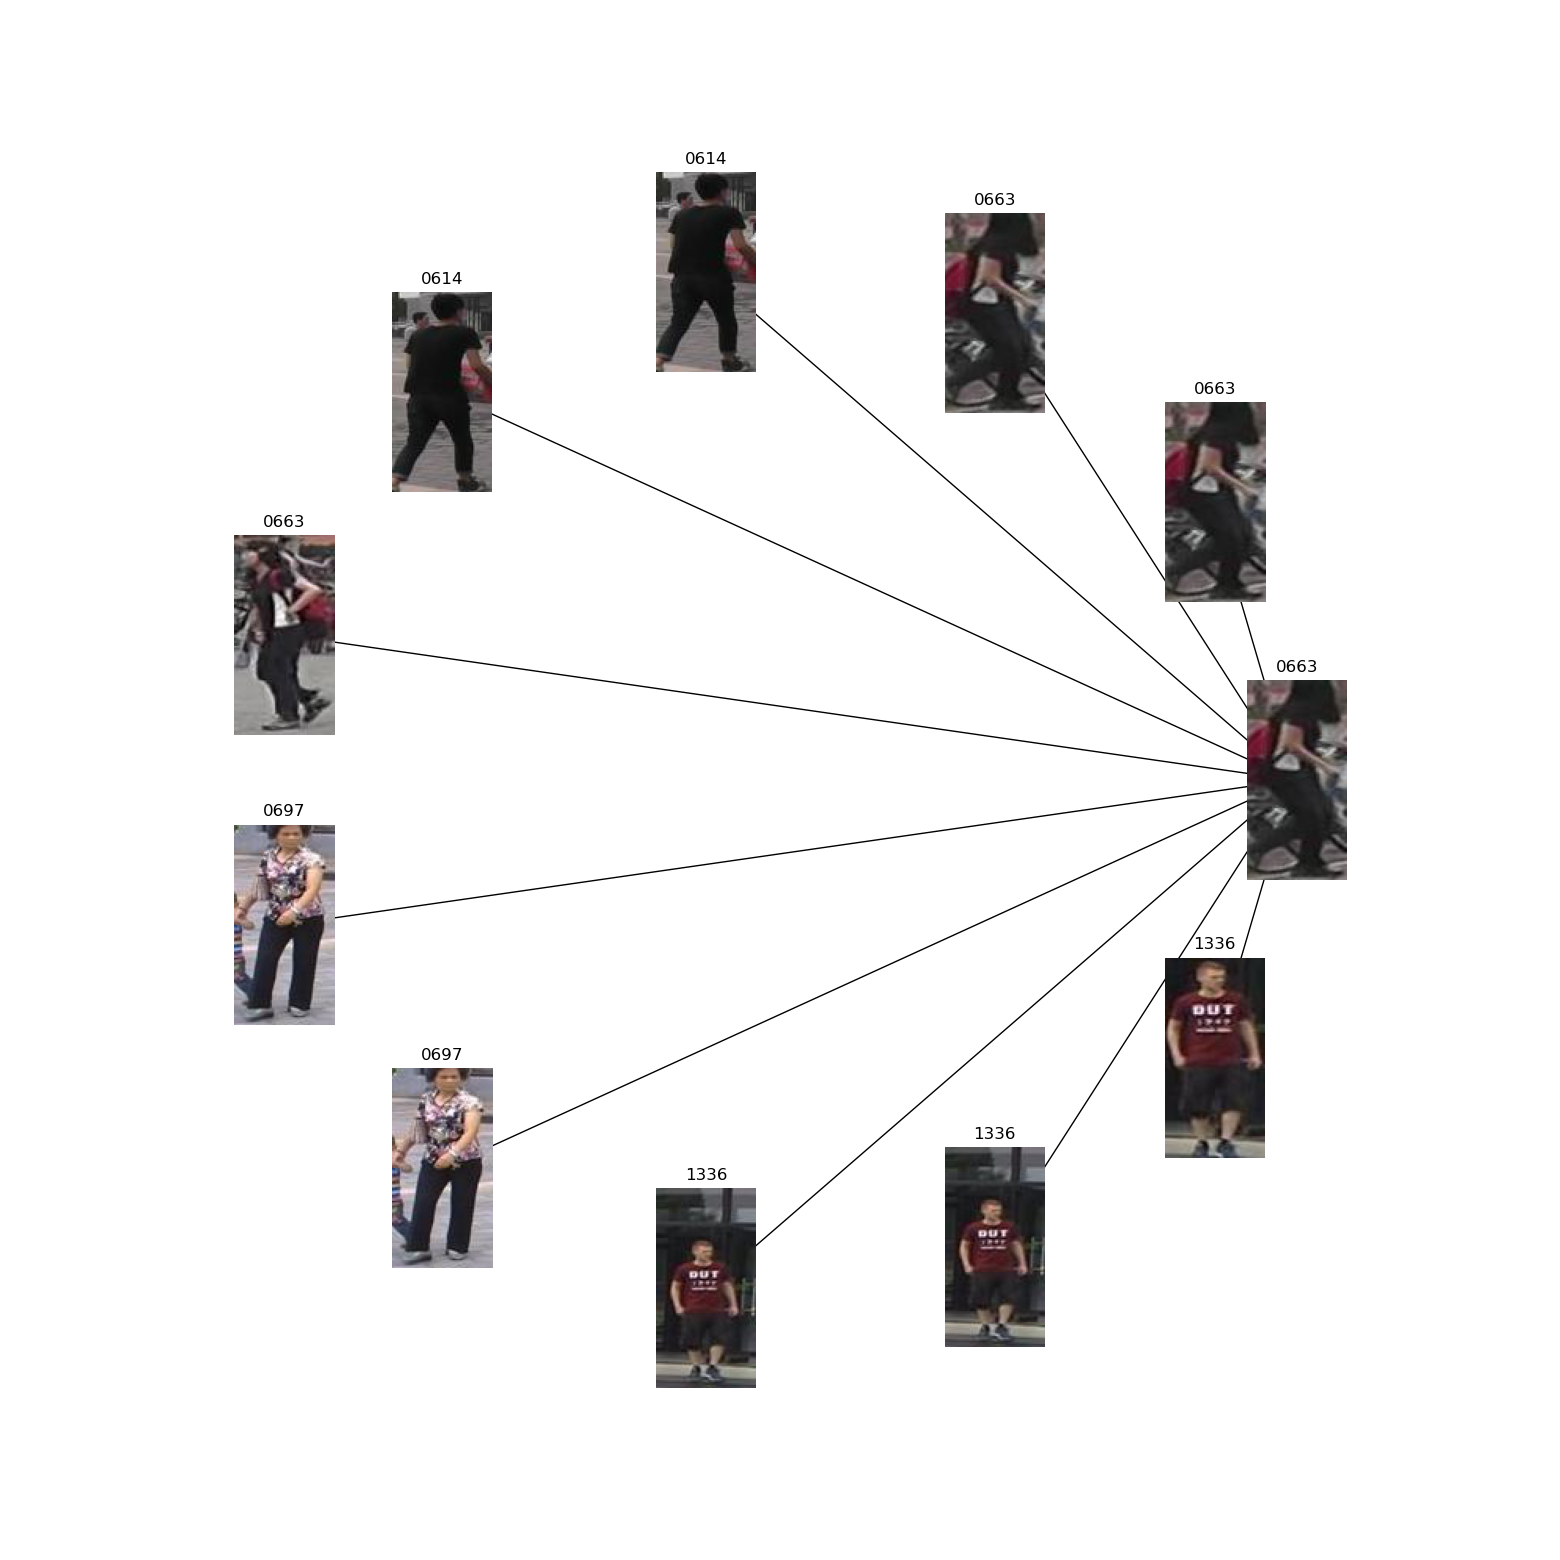

In [42]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 10);